In [30]:
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud

from matplotlib import pyplot as plt
from pandarallel import pandarallel

from reviews.preprocess import preprocess
from reviews.config import processed_data_dir

pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Analysis

In [31]:
data_df = pd.read_json(processed_data_dir / "products_reviews.json.gz")

data_df["asin"] = data_df["asin"].astype("category")
data_df["text"] = data_df["text"].astype("string")
data_df["summary"] = data_df["summary"].astype("string")
data_df["overall"] = data_df["overall"].astype("category")
data_df["brand"] = data_df["brand"].astype("category")
data_df["category"] = data_df["category"].astype("category")
data_df["description"] = data_df["description"].astype("string")
data_df["title"] = data_df["title"].astype("string")

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152368 entries, 0 to 152367
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   asin         152368 non-null  category      
 1   overall      152368 non-null  category      
 2   summary      152368 non-null  string        
 3   text         152368 non-null  string        
 4   timestamp    152368 non-null  datetime64[ns]
 5   vote         152368 non-null  int64         
 6   emoji        152368 non-null  object        
 7   brand        152368 non-null  category      
 8   category     152368 non-null  category      
 9   description  152368 non-null  string        
 10  price        152368 non-null  float64       
 11  title        152368 non-null  string        
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), object(1), string(4)
memory usage: 11.4+ MB


# ASIN

Mean number of reviews: 49.278137128072444


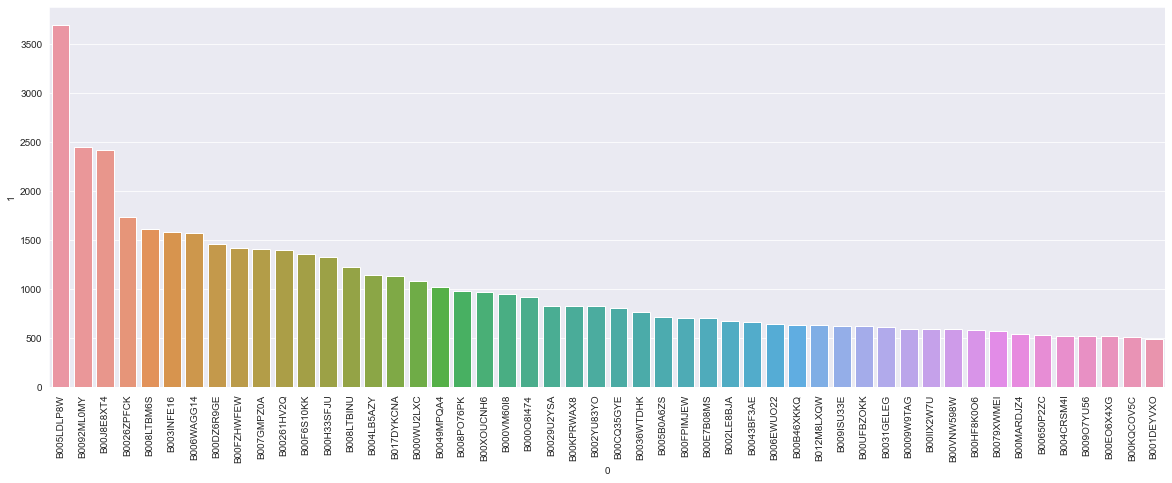

In [32]:
# number of reviews per product(ASIN)
data = pd.DataFrame(Counter(data_df["asin"].tolist()).most_common(50))
_, ax = plt.subplots(figsize=(20, 7))
plt.xticks(rotation=90)
sns.barplot(x=data[0], y=data[1], ax=ax)

# average number of reviews
z = pd.DataFrame(data_df["asin"].value_counts())
print("Mean number of reviews:", z["asin"].mean())

# Title

In [33]:
# most reviewed titles
c = Counter(data_df["title"].astype("string")).most_common(10)
pd.DataFrame(c, columns=["title", "frequency"])

,title,frequency
0,Crucial 2GB Single DDR3/DDR3L 1600 MT/S (PC3-1...,3700
1,Corsair CX Series 500 Watt 80 Plus Bronze Cert...,2450
2,Kingston HyperX FURY 16GB Kit (2x8GB) 1600MHz ...,2424
3,Cooler Master SickleFlow 120 - Sleeve Bearing ...,1734
4,Crucial 4GB Single DDR3/DDR3L 1600 MT/s (PC3-1...,1610
5,Cooler Master Vortex Plus - CPU Cooler with Al...,1579
6,Ballistix Sport 4GB Single DDR3 1600 MT/s (PC3...,1577
7,"EVGA 500 B1, 80+ BRONZE 500W Power Supply, 3 Y...",1461
8,CORSAIR HYDRO SERIES H75 AIO Liquid CPU Cooler...,1415
9,TP-Link TL-WDN4800 N900 Dual Band PCI-E Wirele...,1405


# Price

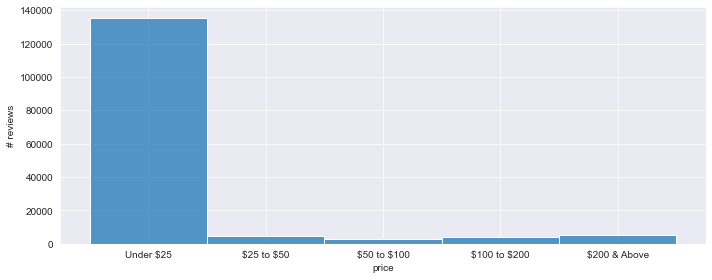

In [110]:
price_categories = pd.CategoricalDtype(
    categories=[
        "Under \$25",
        "\$25 to \$50",
        "\$50 to \$100",
        "\$100 to \$200",
        "\$200 & Above",
    ],
    ordered=True,
)

new_price = data_df["price"].apply(
    lambda price: "Under \$25"
    if price < 25
    else (
        "\$25 to \$50"
        if price < 50
        else (
            "\$50 to \$100"
            if price < 100
            else ("\$100 to \$200" if price < 200 else "\$200 & Above")
        )
    )
)
new_price = new_price.astype(price_categories)


fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(new_price, ax=ax)
ax.set_ylabel("# reviews")
fig.tight_layout()

# Brand & Category

### Most Reviewed Brand

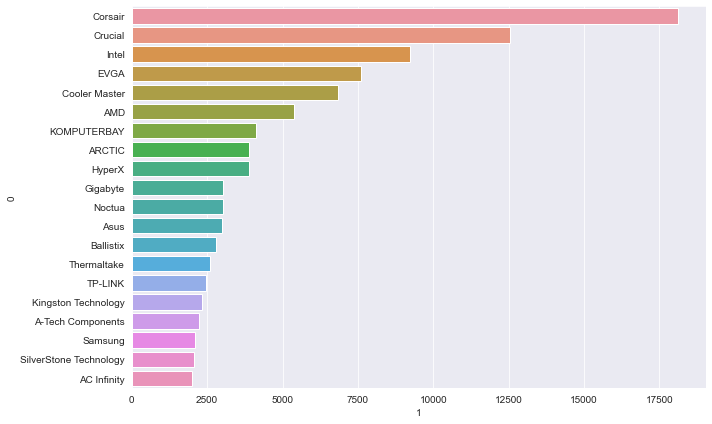

In [35]:
data = pd.DataFrame(Counter(data_df["brand"].tolist()).most_common(20))

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y=data[0], x=data[1], ax=ax)
fig.tight_layout()

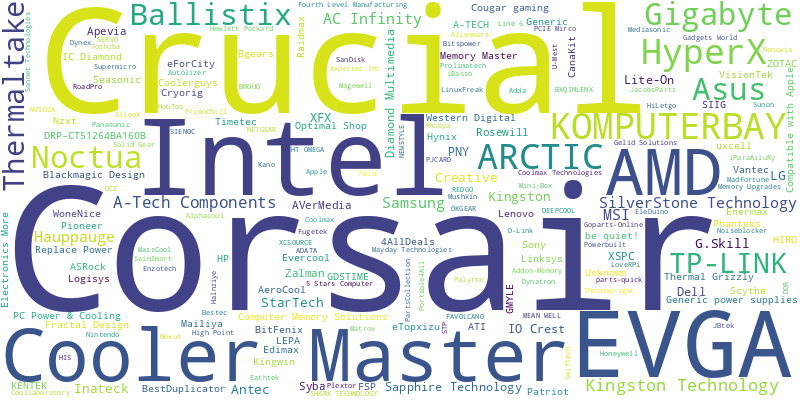

In [36]:
c = Counter(list(data_df["brand"]))
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

### Most Reviewed Categories

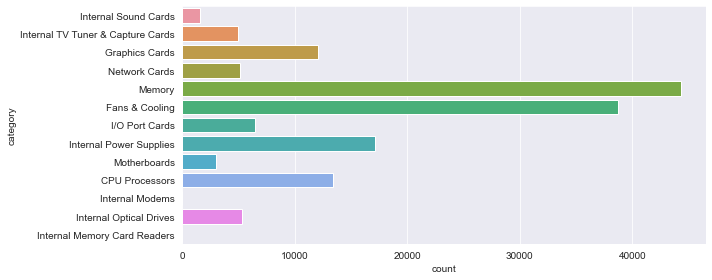

In [37]:
fig = plt.figure(figsize=(10, 4))
ax = sns.countplot(y=data_df["category"].astype("string"))
fig.tight_layout()

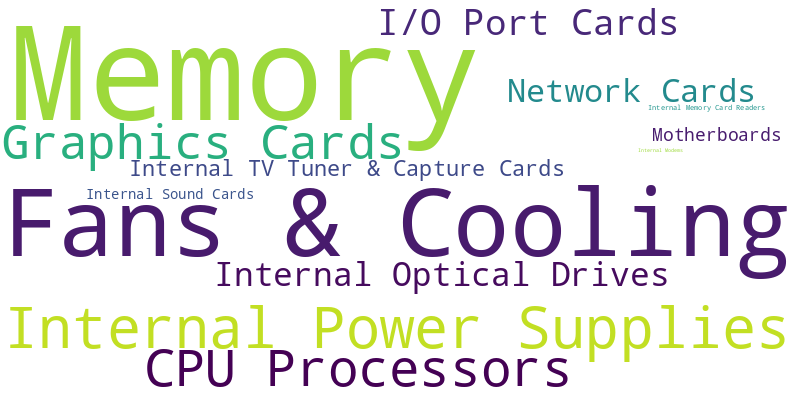

In [38]:
c = Counter(list(data_df["category"]))
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

### Top 5 brand per Category

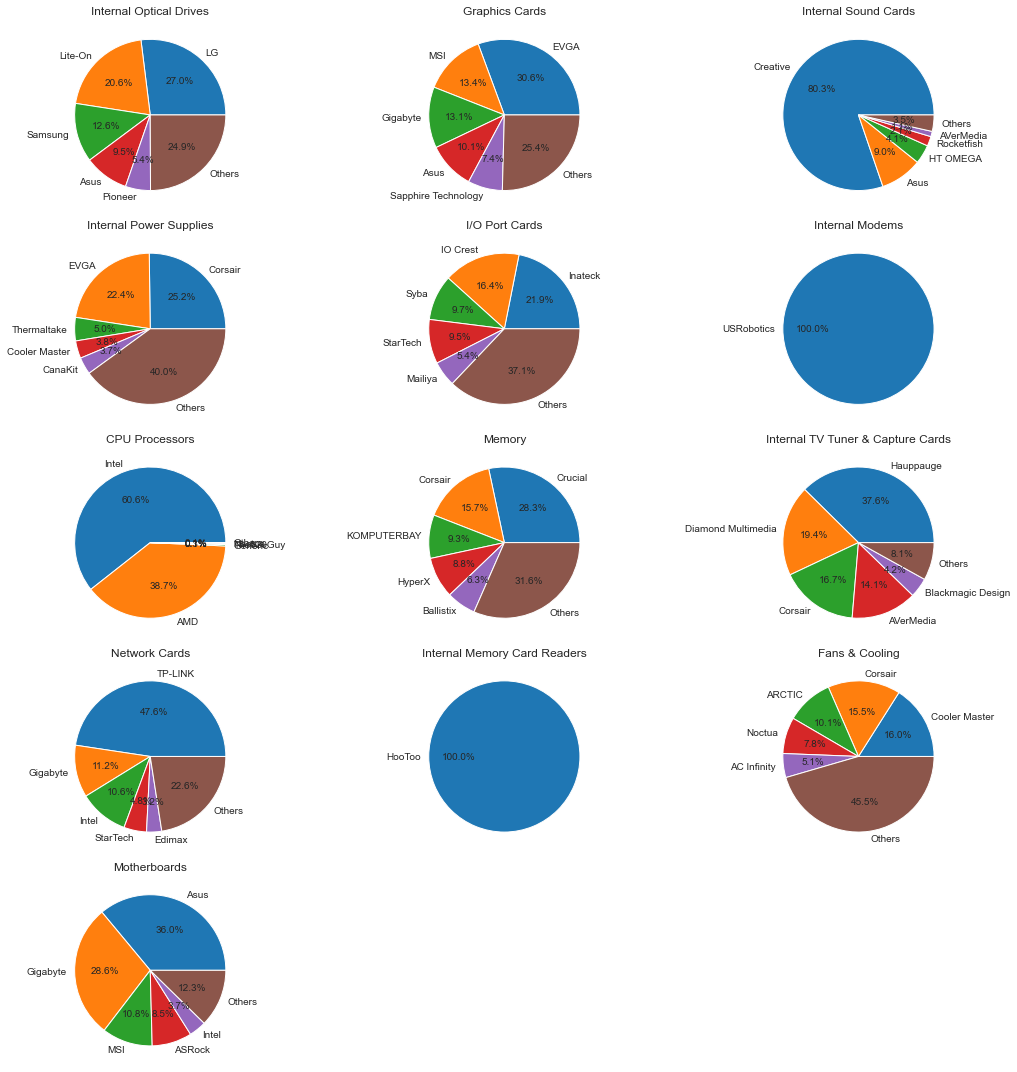

In [108]:
categories = set(data_df["category"])
fig, axes = plt.subplots(5, 3, figsize=(15, 15))
axes = axes.flatten()

for i, cat in enumerate(categories):
    z = data_df.loc[data_df["category"] == cat]["brand"]
    data = pd.DataFrame(
        Counter(z.tolist()).most_common(), columns=["brand", "count"]
    ).reset_index(drop=True)

    if len(data) > 5:
        others = pd.DataFrame(
            data={"brand": ["Others"], "count": [data["count"][5:].sum()]}
        )

        data = pd.concat([data[:5], others])

    data.set_index("brand", inplace=True)

    data.plot(
        y="count",
        x=data.index.values,
        kind="pie",
        legend=False,
        autopct="%1.1f%%",
        ax=axes[i],
    )

    axes[i].set_title(cat)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
fig.tight_layout()

# Review Time Series

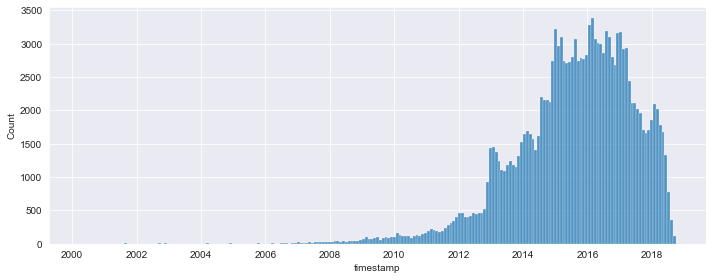

In [40]:
# number of reviews over time of the brand X

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(data_df["timestamp"], ax=ax)
fig.tight_layout()

# Review Text and Summary

### Summary

In [41]:
data_df["summary"].head(20)

0         Easy to Use, Almost everything you could want
1                                               Bathtub
2                          Good low-end, no-hassle card
3                  Ok for the price and basic functions
4                                    Ordered by mistake
5                                  Bad out of box board
6              Creative Labs Soundblaster 16 Sound card
7                              Does not work for Dos :(
8                          An effective basic soundcard
9        Works great, if you can get it to work at all.
10                           Very useful for some tasks
11              Good tool for compressed video captrure
12    It works but prepare to spend time troubleshoo...
13       If you think AOL is GREAT, don't buy a Dazzle.
14    Never buy a PCI TV Card!  ATI TV cards are gre...
15                                         Good product
16     If it works for you then you are in the minority
17                             More like the TV 

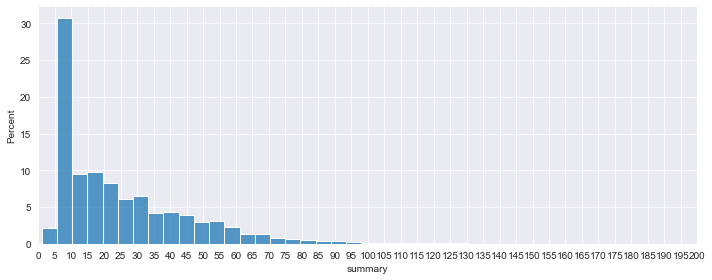

In [42]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_xlim([0, 200])
ax.set_xticks(range(0, 205, 5))
sns.histplot(data_df["summary"].str.len(), stat="percent", bins=50, ax=ax)
fig.tight_layout()

In [43]:
mean_length = np.round(np.mean(data_df["summary"].str.len()))
print("mean summary length:", mean_length, "characters")

data_df[data_df["summary"].str.len() == mean_length]["summary"].head(30)

mean summary length: 26 characters


10      Very useful for some tasks
18      It Works with Windows XP!!
26      ICS function will not work
235     Works just like it should!
253     You can flip the direction
272     Easy fix for extra cooling
273     Suprisingly great air flow
277     Great product, Great Price
306     Somewhat noisy, but works.
386     Excellent streaming device
642     The product have problem..
703     Decent range for the price
727     Old as heck, but it works.
755     Best buy for PC 133 SD RAM
771     Generic SDRAM Works Great!
884     A fan of this purchase <.<
898     Brainlessly simple install
1067    Wrong brand and defective.
1138    good value, GREAT product!
1151    Exactly what my PC needed!
1162    Good Product for the price
1219    very worthwhile investment
1241    Not reliable unfortunately
1244    Great addition to slow PC.
1245    PC270 184 pin 512MB memory
1310    Very Easy To Install & Use
1314    Perfect match for any Mac!
1352    Great Memory for the Price
1388    sped up my I

In [44]:
# top 3 most common summary length
len10 = set(data_df[data_df["summary"].str.len() == 10]["summary"].head(20))
len11 = set(data_df[data_df["summary"].str.len() == 11]["summary"].head(20))
len9 = set(data_df[data_df["summary"].str.len() == 9]["summary"].head(20))

print(len10, "\n\n", len11, "\n\n", len9)

{'I love it!', 'old memory', 'Four Stars', 'Five Stars', 'its memory', 'Works well'} 

 {'cool man !!', 'Great RAM !', 'Worked fine', 'BAD. AVOID.', 'pretty good', 'Works great', 'Three Stars', 'Very noisy.', 'No problems', 'great value', 'Fanless Fan', 'Works good.', 'Think twice', 'Works Great', 'works great', 'Outstanding'} 

 {'Two Stars', 'Great fan', "Don't buy", 'Great fx.', 'High flow', 'FANTASTIC', 'No workie', 'great fan', "it's okay", 'Good Deal', 'Great Fan', 'Beautiful'}


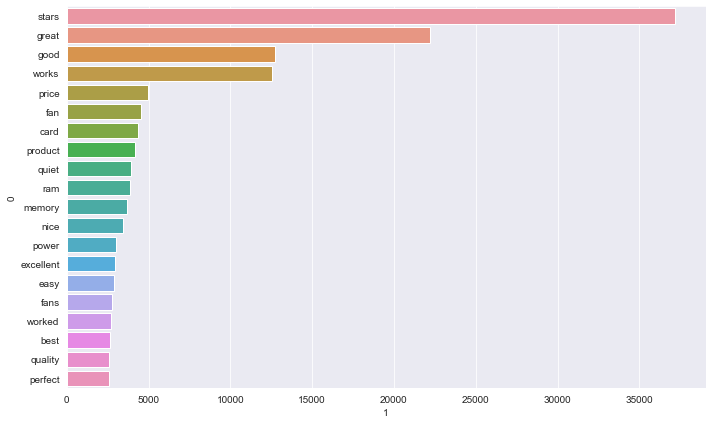

In [56]:
# most common tokens summary
tokens = []
for x in data_df["summary"].tolist():
    for sentence in preprocess(x, sentences=True):
        for token in sentence:
            tokens.append(token)

data = pd.DataFrame(Counter(tokens).most_common(20))

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y=data[0], x=data[1], ax=ax)
fig.tight_layout()

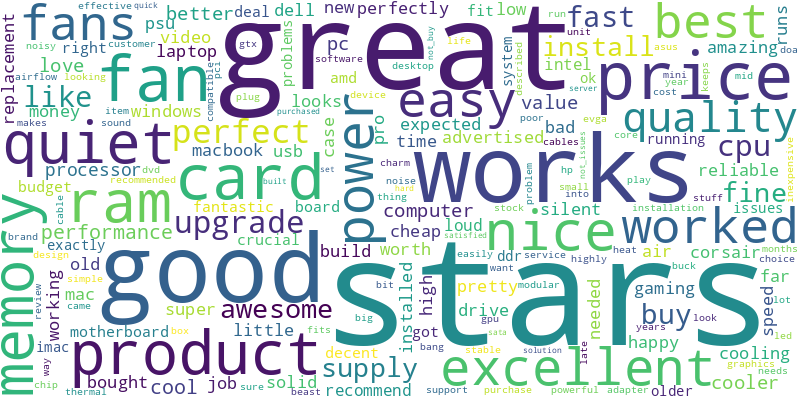

In [46]:
c = Counter(tokens)
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

### Text

In [47]:
data_df["text"].head(20)

0     This sound card doesn't reproduce MP3 or WAV f...
1     Essentially, this is the entry-level, 16-bit a...
2     This is a basic sound card.  Nothing fancy.  T...
3     This is a basic low-end sound card. It puts ou...
4     Ordered these by mistake. My computer didn't n...
5     I installed per instructions, beign always gro...
6     I have owned other sound blaster sound cards. ...
7     This pci card works but unfortunatly i needed ...
8     I keep a lot of computer equipment at home, du...
9     First time I plugged it in and installed the d...
10    The Dazzle Multimedia DM4100 Digital Video Cre...
11    The USB version of the Dazzle DM4100 video cap...
12    If you want to convert your VHS video tapes in...
13    Ignore all the unfavorable reviews of the Dazz...
14    What happens, is that PCI TV cards clog up you...
15    I purchased the lower end version of this prod...
16    I've probably invested more than ten hours int...
17    This was a good starter card for watching 

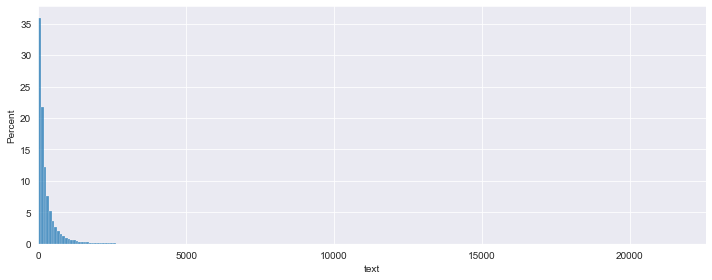

In [65]:
text_lengths = data_df["text"].str.len()

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(text_lengths, stat="percent", bins=250, ax=ax)
ax.set_xlim([0, np.max(text_lengths)])
fig.tight_layout()

In [67]:
mean_length = np.round(np.mean(text_lengths))
print("mean text length:", mean_length, "characters")

data_df[text_lengths == mean_length]["text"].head(10)

mean text length: 286.0 characters


250     This blower is amazing!  It does move a lot of...
3327    This processor is very nice, it works very wel...
4111    Switching power supply is common for computers...
4368    This fan is very bulky.  Make sure you have pl...
5795    I purchased this ram upgrade for my late 2007 ...
6309    Orignially I bought this for usb driving. Unfo...
7430    Not sure what else to say - they work, and are...
8692    I was upgrading the RAM in my 2007-2008 white ...
8778    I have used Crucial me,ory in the past and hav...
9411    this thing is a monster and thats all that nee...
Name: text, dtype: string

In [68]:
# top 3 most common text length
len9 = set(data_df[text_lengths == 9]["text"].head(10))
len12 = set(data_df[text_lengths == 12]["text"].head(10))
len11 = set(data_df[text_lengths == 11]["text"].head(10))

print(len9, "\n\n", len12, "\n\n", len11)

{'thank you', 'very loud', 'It is ok.', 'good deal', 'expensive', 'Very Good', 'excellent', 'Excellent'} 

 {'Good product', 'Good Product', 'worked great', 'As described', 'No problems.', 'as described', 'Still works.'} 

 {'As Expected', 'Works great', 'Great deal!', 'good memory', 'didnot work', 'Works well.', 'works great'}


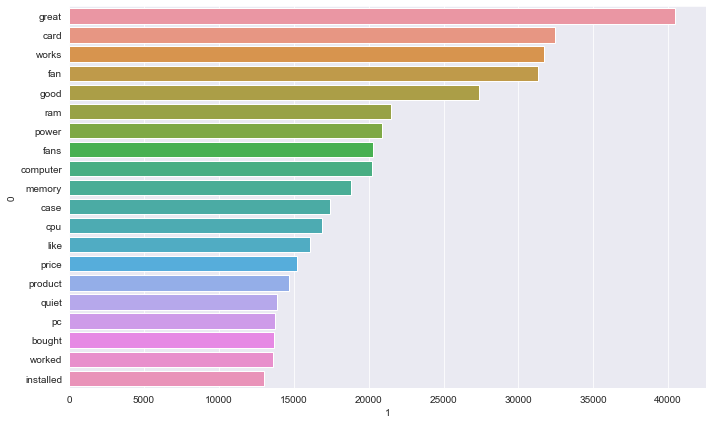

In [69]:
# most common tokens summary
tokens = []
for x in data_df["text"].tolist():
    for sentence in preprocess(x, sentences=True):
        for token in sentence:
            tokens.append(token)

data = pd.DataFrame(Counter(tokens).most_common(20))

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y=data[0], x=data[1], ax=ax)
fig.tight_layout()

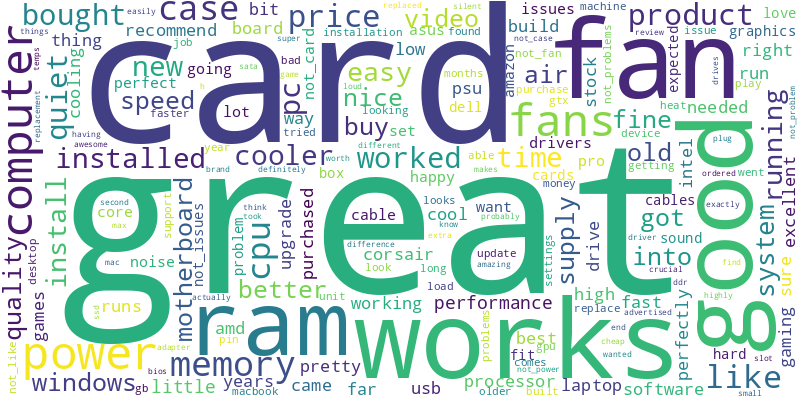

In [70]:
c = Counter(tokens)
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

### SUMMARY + TEXT

In [71]:
summary_text = []
for i, row in data_df.iterrows():
    end_line = ".\n"
    if row["summary"].endswith("."):
        end_line = "\n"
    summary_text.append(row["summary"] + end_line + row["text"])
data_df["summary+text"] = summary_text

for i in range(3):
    print(data_df["summary+text"][i], "\n")

Easy to Use, Almost everything you could want.
This sound card doesn't reproduce MP3 or WAV files any differently than a more expensive card would.  Creative Labs has always made great cards and drivers.  The only thing this card doesn't give you that the more expensive card do is the 3d sound effects when playing video games, and true Dolby 5.1 for DVD playback.  However, I doubt many people are setup for this situation, and many people do not watch DVD's or play games.  If this is you, this card is perfect for you.  If you are a gamer then this card will work perfectly fine.  I personally find the 3d effects annoying, and prefer to play on a card like this.  I highly recomend this card. 

Bathtub.
Essentially, this is the entry-level, 16-bit audio Creative Labs sound  card. It has a built-in mock '3D' stereo effect, a 128-voice MIDI  wavetable, and it can sample at up to 48khz in 16-bit stereo, and that's  about all there is to it. Whilst it doesn't do anything wrong in itself  (it's

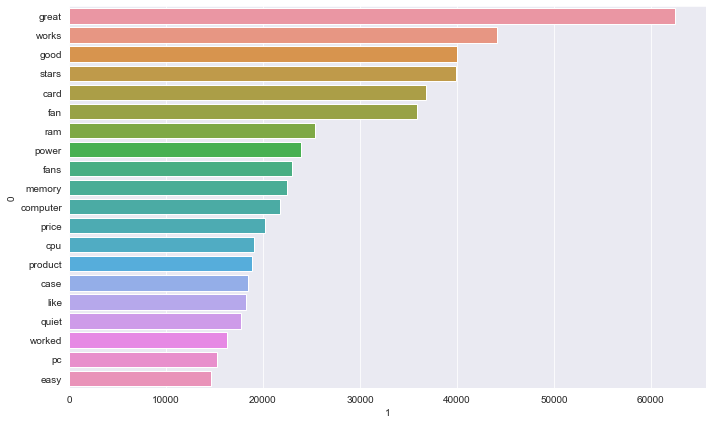

In [72]:
# most common tokens summary
tokens = []
for x in data_df["summary+text"].tolist():
    for sentence in preprocess(x, sentences=True):
        for token in sentence:
            tokens.append(token)

data = pd.DataFrame(Counter(tokens).most_common(20))

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y=data[0], x=data[1], ax=ax)
fig.tight_layout()

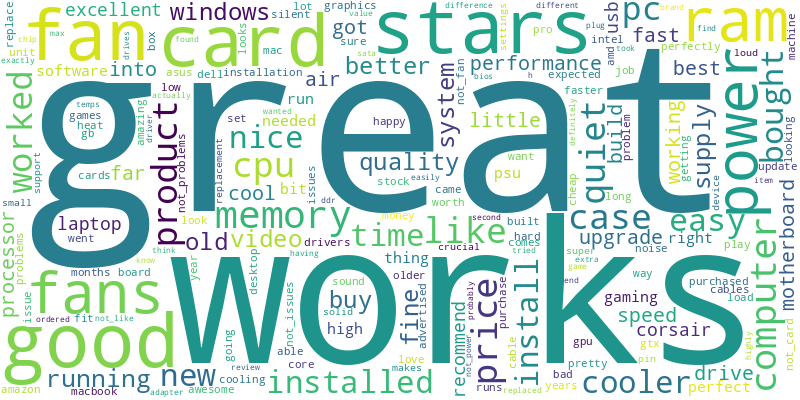

In [73]:
c = Counter(tokens)
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

# Overall

<AxesSubplot:ylabel='overall'>

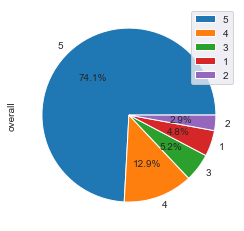

In [74]:
# number by starts
data_df["overall"].value_counts(normalize=True).plot(
    kind="pie", legend=True, autopct="%1.1f%%"
)

<AxesSubplot:ylabel='overall'>

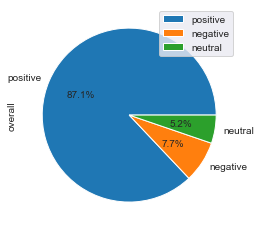

In [75]:
# ground truth polarity
polarity_overall = data_df["overall"].parallel_apply(
    lambda o: "positive" if o > 3 else ("neutral" if o == 3 else "negative")
)
polarity_overall.value_counts(normalize=True).plot(
    kind="pie", legend=True, autopct="%1.1f%%"
)

/tmp/ipykernel_69015/2185227570.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["polarity_overall"] = polarity_overall


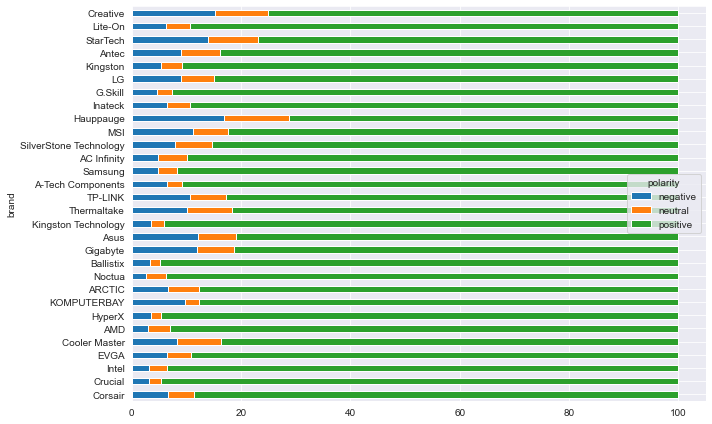

In [92]:
fig, ax = plt.subplots(figsize=(10, 6))

data = pd.DataFrame(Counter(data_df["brand"]).most_common(30))

data = data_df.loc[data_df["brand"].isin(set(data[0]))]
data["polarity_overall"] = polarity_overall
x = (
    data[["brand", "polarity_overall"]]
    .value_counts()
    .rename_axis(["brand", "polarity"])
    .reset_index(name="count")
)
x = x.pivot(columns="polarity", index="brand", values="count")

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="brand", kind="barh", stacked=True, ax=ax)
fig.tight_layout()

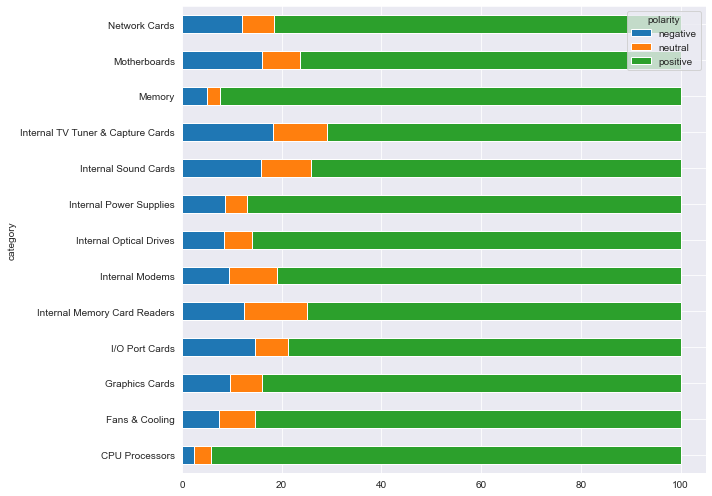

In [88]:
fig, ax = plt.subplots(figsize=(10, 7))

data_df["polarity_overall"] = polarity_overall
x = (
    data_df.groupby("category")["polarity_overall"]
    .value_counts()
    .rename_axis(["category", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="category", values="polarity_overall")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="category", kind="barh", stacked=True, ax=ax)
fig.tight_layout()

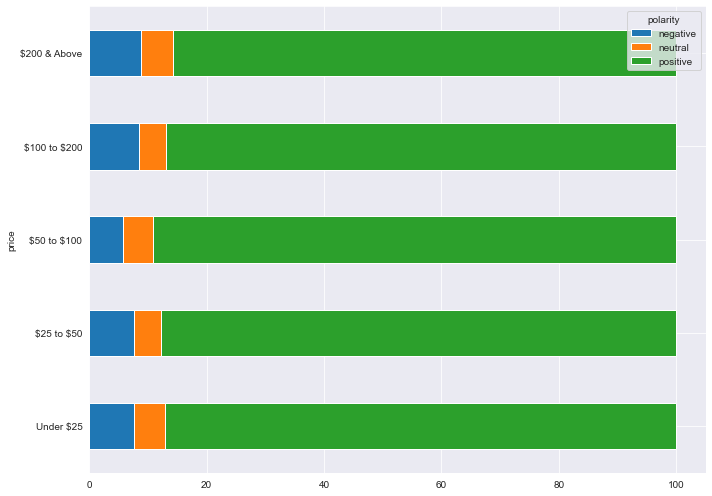

In [93]:
fig, ax = plt.subplots(figsize=(10, 7))

data_df["new_price"] = new_price
x = (
    data_df.groupby("new_price")["polarity_overall"]
    .value_counts()
    .rename_axis(["price", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="price", values="polarity_overall")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="price", kind="barh", stacked=True, ax=ax)
fig.tight_layout()

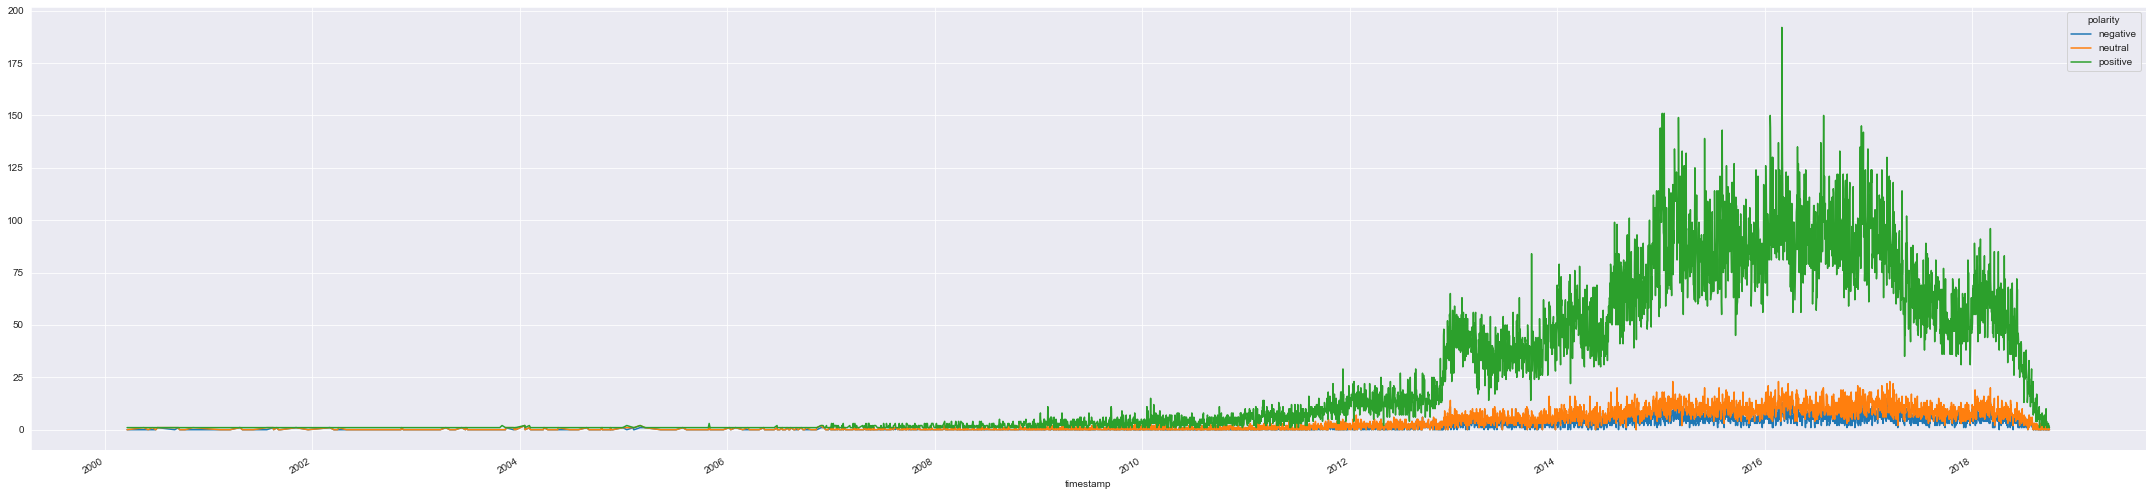

In [94]:
# Overall over time

fig, ax = plt.subplots(figsize=(30, 7))
plt.xticks(rotation=90)

x = (
    data_df.groupby("timestamp")["polarity_overall"]
    .value_counts()
    .rename_axis(["timestamp", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="timestamp", values="polarity_overall")
)
x.reset_index(inplace=True)

x.plot(x="timestamp", kind="line", stacked=True, ax=ax)
fig.tight_layout()

# Vote

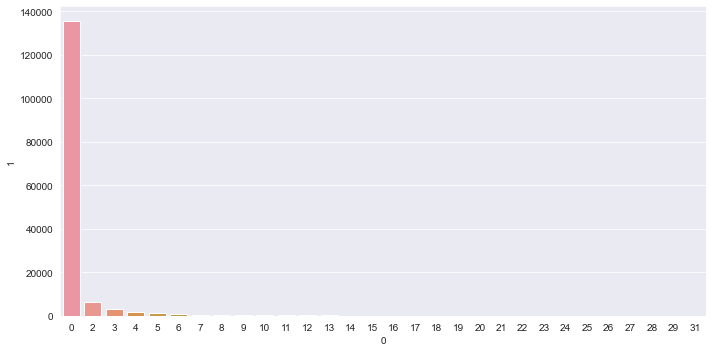

In [99]:
# count of helpful vote number

data = pd.DataFrame(Counter(data_df["vote"].tolist()).most_common(30))
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=data[0], y=data[1], ax=ax)
fig.tight_layout()

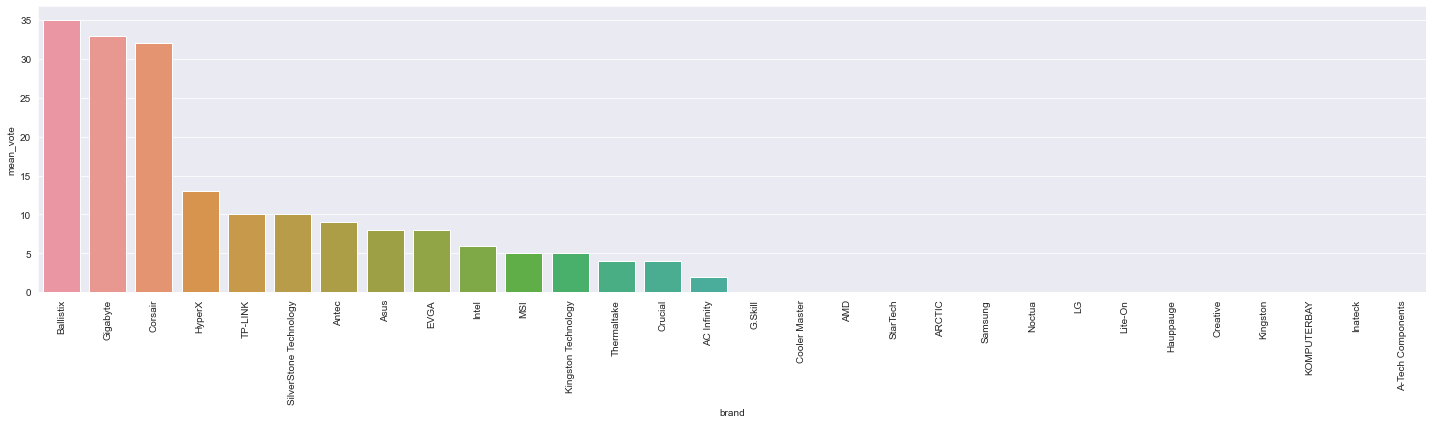

In [100]:
# mean number of util vote for brand

df = data_df.copy()
c = pd.DataFrame(Counter(list(df["brand"])).most_common(30))
df["brand"] = c[0]
df = df.groupby(["brand"]).agg({"vote": [np.mean]})
df.columns = ["mean_vote"]
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(
    x=df["brand"],
    y=df["mean_vote"],
    ax=ax,
    order=df.sort_values(by="mean_vote", ascending=False).brand,
)
plt.xticks(rotation=90)
fig.tight_layout()

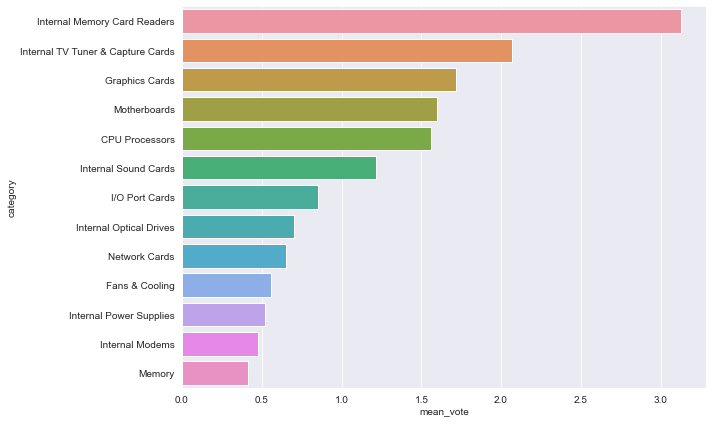

In [105]:
# mean number of util vote for category

df = data_df.copy()
df = df.groupby(["category"]).agg({"vote": [np.mean]})
df.columns = ["mean_vote"]
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    y=df["category"],
    x=df["mean_vote"],
    ax=ax,
    order=df.sort_values(by="mean_vote", ascending=False).category,
)
fig.tight_layout()

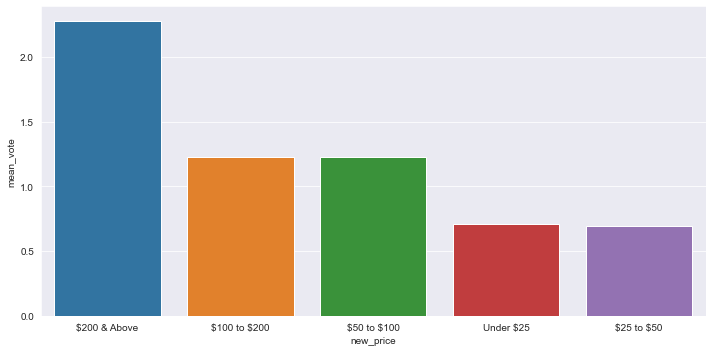

In [107]:
# mean number of util vote for price

df = data_df.copy()
df["new_price"] = new_price

df = df.groupby(["new_price"]).agg({"vote": [np.mean]})
df.columns = ["mean_vote"]
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    x=df["new_price"],
    y=df["mean_vote"],
    ax=ax,
    order=df.sort_values(by="mean_vote", ascending=False).new_price,
)
fig.tight_layout()